<a href="https://www.kaggle.com/code/paulachiaramonte/spotify-recommendation?scriptVersionId=91148018" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from sklearn.preprocessing import OrdinalEncoder
from sklearn.cluster import KMeans

from scipy import stats
from sklearn.preprocessing import StandardScaler

from sklearn.metrics.pairwise import cosine_similarity

pd.options.mode.chained_assignment = None  # default='warn'

## Data Cleaning and Transformation

In [2]:
data = pd.read_csv("../input/ultimate-spotify-tracks-db/SpotifyFeatures.csv")
data.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


Removed the variables of "key" and "time_signature", and ended up with the following variables

In [3]:
indx = data[['track_name', 'artist_name']]
attributes = data.drop(['track_id', 'time_signature','track_name', 'artist_name', 'key'], axis = 1)
attributes.head()

,genre,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,valence
0,Movie,0,0.611,0.389,99373,0.910,0.000,0.3460,-1.828,Major,0.0525,166.969,0.814
1,Movie,1,0.246,0.590,137373,0.737,0.000,0.1510,-5.559,Minor,0.0868,174.003,0.816
2,Movie,3,0.952,0.663,170267,0.131,0.000,0.1030,-13.879,Minor,0.0362,99.488,0.368
3,Movie,0,0.703,0.240,152427,0.326,0.000,0.0985,-12.178,Major,0.0395,171.758,0.227
4,Movie,4,0.950,0.331,82625,0.225,0.123,0.2020,-21.150,Major,0.0456,140.576,0.390


Transformed the qualitative predictors (genre and mode) in binary predictors, and merged the songs genres into one row representing a single song

In [4]:
ordinal_encoder = OrdinalEncoder()
object_cols = ['mode']
attributes[object_cols] = ordinal_encoder.fit_transform(attributes[object_cols])

attributes = pd.get_dummies(attributes)
attributes.insert(loc=0, column='track_name', value=indx.track_name)
attributes.insert(loc=1, column = 'artist_name', value = indx.artist_name)


In [5]:
genres_names = ['genre_A Capella', 'genre_Alternative', 'genre_Anime', 'genre_Blues',
       "genre_Children's Music", "genre_Children’s Music", 'genre_Classical',
       'genre_Comedy', 'genre_Country', 'genre_Dance', 'genre_Electronic',
       'genre_Folk', 'genre_Hip-Hop', 'genre_Indie', 'genre_Jazz',
       'genre_Movie', 'genre_Opera', 'genre_Pop', 'genre_R&B', 'genre_Rap',
       'genre_Reggae', 'genre_Reggaeton', 'genre_Rock', 'genre_Ska',
       'genre_Soul', 'genre_Soundtrack', 'genre_World']

In [6]:
genres = attributes.groupby(['track_name', 'artist_name'])[genres_names].sum()

column_names = ['track_name', 'artist_name']
for i in genres_names:
    column_names.append(i)

genres.reset_index(inplace=True)
genres.columns = column_names

attributes = attributes.drop(genres_names, axis = 1)

atts_cols = attributes.drop(['track_name', 'artist_name'], axis = 1).columns
scaler = StandardScaler()
attributes[atts_cols] = scaler.fit_transform(attributes[atts_cols])

songs = pd.merge(genres, attributes, how = 'inner', on = ['track_name', "artist_name"])
songs = songs.drop_duplicates(['track_name', 'artist_name']).reset_index(drop = True)


In [7]:
songs.head()

,track_name,artist_name,genre_A Capella,genre_Alternative,genre_Anime,genre_Blues,genre_Children's Music,genre_Children’s Music,genre_Classical,genre_Comedy,...,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,valence
0,""" La Traviata "" : Amami Alfredo (Act II) - Dig...",Maria Callas,0,0,0,0,0,0,0,0,...,-1.025627,-0.867606,-1.123371,-0.396017,0.393352,-0.377133,-0.730526,-0.419178,-1.021740,-1.597743
1,"""1点""",Yuki Hayashi,0,0,1,0,0,0,0,0,...,-1.639826,-0.648438,0.725142,1.214458,-0.610319,-0.537515,1.368876,-0.398695,-0.924746,-1.428170
2,"""42"" - From SR3MM",Rae Sremmurd,0,0,0,0,0,0,0,0,...,2.228546,0.024363,-0.030205,-0.489819,-0.539709,0.471123,-0.730526,0.022828,0.400417,-0.503401
3,"""45""",The Gaslight Anthem,0,0,0,0,0,0,0,0,...,-1.289625,-0.274344,1.514651,-0.489819,0.312655,0.810392,-0.730526,-0.101149,1.954812,-0.122726
4,"""6人で(強い方が強い)""",Yuki Hayashi,0,0,1,0,0,0,0,0,...,-2.038516,-0.539135,-1.692728,2.495969,-0.433794,-1.188544,-0.730526,-0.462839,0.595796,-1.571980


## Exploratory Data Analysis

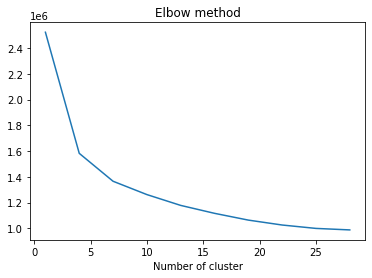

In [8]:
sse={}
DF = pd.DataFrame(songs.drop(['track_name', 'artist_name'], axis = 1))
for k in range(1, 30,3):
    kmeans = KMeans(n_clusters=k, max_iter=100).fit(DF)
    DF["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.title("Elbow method")
plt.xlabel("Number of cluster")
plt.show()

In [9]:
DF = pd.DataFrame(songs.drop(['track_name', 'artist_name'], axis = 1))
kmeans = KMeans(n_clusters=17)
songs['Cluster'] = kmeans.fit_predict(DF)

## K-Nearest Neighbors with Cosine Distance model

In [10]:
def find_song_database(name, artist, songs):
    result = songs[(songs.artist_name == str(artist)) & (songs.track_name == str(name))]
    if len(result) == 0:
        return None
    return result.drop(['track_name', 'artist_name', 'Cluster'], axis = 1)

def find_similar(name, artist, songs, top_n = 5):
    database = songs[songs.popularity > 0.5].reset_index(drop = True)
    indx_names = database[['track_name', 'artist_name', 'Cluster']]
    songs_train = database.drop(['track_name', 'artist_name', 'Cluster'], axis = 1)

    song = find_song_database(str(name), str(artist), database)
    
    if type(song) != type(None):
        indx_song = song.index

        cos_dists = cosine_similarity(songs_train, songs_train)
        indx_names.loc[:,['result']] = cos_dists[indx_song[0]]

        indx_names = indx_names.sort_values(by = ['result'], ascending = False)

        return indx_names[1:top_n].reset_index(drop = True)
    
    else:
        print("Song not found")
        return None
    
    
def playlist_song(name, artist, songs, n_songs = 10):
    list_songs = find_similar(str(name), str(artist), songs, n_songs)
    
    if type(list_songs) != type(None):
    
        print('Playlist based on "' + str(name) + '" by ' + str(artist))
        print()

        for i in np.arange(0,len(list_songs)):
            track_name = list_songs.track_name[i]
            artist_name = list_songs.artist_name[i]

            print(str(track_name) + ' - ' + str(artist_name))
            
    return None

To try the playlist creator based on a song, we tested it with different songs: 

In [11]:
playlist_song('All Of The Lights', 'Kanye West', songs, 10)

Playlist based on "All Of The Lights" by Kanye West

STARGAZING - Travis Scott
Deja Vu - Post Malone
SICKO MODE - Skrillex Remix - Travis Scott
Summer - Marshmello
Rich & Sad - Post Malone
Don't Play - Travis Scott
Magic Shop - BTS
All The Above [feat. T-Pain] - Maino
Paranoid - Post Malone


In [12]:
playlist_song('Across The Universe - Remastered 2009', "The Beatles",  songs, 10)

Playlist based on "Across The Universe - Remastered 2009" by The Beatles

The Man in Me - Bob Dylan
Roll Over Beethoven - Remastered 2009 - The Beatles
Gotta Get Up - Remastered - Harry Nilsson
Norwegian Wood (This Bird Has Flown) - Remastered 2009 - The Beatles
Sweet Leaf - Remastered Version - Black Sabbath
Take Me Home, Country Roads - Rerecorded - John Denver
Afternoon Delight - Starland Vocal Band
The Joker - Steve Miller Band
Back Door Man - The Doors


In [13]:
playlist_song('Skinny Love', "Bon Iver",  songs, 10)

Playlist based on "Skinny Love" by Bon Iver

Elijah - Matthew And The Atlas
Chandelier - Kina Grannis
San Luis - Gregory Alan Isakov
Fresh Roses - Juke Ross
Ordinary World - Joy Williams
Sea of Love - Cat Power
Be Your Man - Rhys Lewis
Sinking Ship - Wild Child
Alcatraz - Oliver Riot


In [14]:
playlist_song('Style', "Taylor Swift",  songs, 10)

Playlist based on "Style" by Taylor Swift

Drowning - KREAM
All You Had To Do Was Stay - Taylor Swift
Perfect - One Direction
EASE - Troye Sivan
Ghost - Ella Henderson
Sober - P!nk
Rise - Katy Perry
That's the Way It Is - Céline Dion
YOUTH - Troye Sivan
